# Brest Cancer Classification

This Dataset is taken from: https://www.kaggle.com/competitions/rsna-breast-cancer-detection/data

The Dataset contains radiographic breast images of female subjects.

Files are mammograms, in dicom format.There are usually but not always 4 images per patient. Note that many of the images use the jpeg 2000 format which may you may need special libraries to load.

The metadata contains the following data:

*  site_id - ID code for the source hospital.
*  patient_id - ID code for the patient.
*  image_id - ID code for the image.
*  laterality - Whether the image is of the left or right breast.
*  view - The orientation of the image. The default for a screening exam is to capture two views    per breast.
*  age - The patient's age in years.
*  implant - Whether or not the patient had breast implants. Site 1 only provides breast implant    information at     the patient level, not at the breast level.
*  density - A rating for how dense the breast tissue is, with A being the least dense and D        being the most         dense. Extremely dense tissue can make diagnosis more difficult. Only      provided for train.
*  machine_id - An ID code for the imaging device.
*  cancer - Whether or not the breast was positive for malignant cancer. The target value. Only      provided for       train.
*  biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for        train.
*  invasive - If the breast is positive for cancer, whether or not the cancer proved to be          invasive. Only           provided for train.
*  BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer,    and 2 if the     breast was rated as normal. Only provided for train.
*  prediction_id - The ID for the matching submission row. Multiple images will share the same      prediction ID.       Test only.
*  difficult_negative_case - True if the case was unusually difficult. Only provided for train.

## Set-up

The data are in the DICOM format. Some of the images are compressed in JPEG2000 format so special libraries are needed for loading those images.

In [3]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.5 MB/s eta 0:00:0000:0100:01


In [3]:
!unzip -q ../input/timm-with-dependencies/timm_all -d timm-with-dependencies
!pip install --no-index --find-links timm-with-dependencies timm


# This is a dependency that is needed for reading DICOM images

try:
    import pylibjpeg
except:
    !rm -rf /root/.cache/torch/hub/checkpoints/
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

unzip:  cannot find or open ../input/timm-with-dependencies/timm_all, ../input/timm-with-dependencies/timm_all.zip or ../input/timm-with-dependencies/timm_all.ZIP.
Looking in links: timm-with-dependencies


In [4]:
import cv2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pydicom
from pydicom import dcmread
import pylibjpeg

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Data

In [6]:
labels = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

In [7]:
labels.head(20)


site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0         2       10006   462822612          L   CC  61.0       0       0   
1         2       10006  1459541791          L  MLO  61.0       0       0   
2         2       10006  1864590858          R  MLO  61.0       0       0   
3         2       10006  1874946579          R   CC  61.0       0       0   
4         2       10011   220375232          L   CC  55.0       0       0   
5         2       10011   270344397          L  MLO  55.0       0       0   
6         2       10011   541722628          R   CC  55.0       0       0   
7         2       10011  1031443799          R  MLO  55.0       0       0   
8         2       10025   562340703          L   CC  75.0       0       0   
9         2       10025  1365269360          L  MLO  75.0       0       0   
10        2       10025   288394860          R   CC  75.0       0       0   
11        2       10025   893612858          R  MLO  75.0       0       0   
12        1       10038  1967300488          L  MLO  60.0       0       0   
13        1       10038  2142944869          L   CC  60.0       0       0   
14        1       10038   850559196          R  MLO  60.0       0       0   
15        1       10038  1350492010          R   CC  60.0       0       0   
16        1       10042   102733848          L   CC  51.0       0       0   
17        1       10042   202939811          L  MLO  51.0       0       0   
18        1       10042  1648588715          L  MLO  51.0       0       0   
19        1       10042   294481519          R   CC  51.0       0       0   

    invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0          0     NaN        0     NaN          29                    False  
1          0     NaN        0     NaN          29                    False  
2          0     NaN        0     NaN          29                    False  
3          0     NaN        0     NaN          29                    False  
4          0     0.0        0     NaN          21                     True  
5          0     0.0        0     NaN          21                     True  
6          0     NaN        0     NaN          21                    False  
7          0     NaN        0     NaN          21                    False  
8          0     NaN        0     NaN          29                    False  
9          0     NaN        0     NaN          29                    False  
10         0     NaN        0     NaN          29                    False  
11         0     NaN        0     NaN          29                    False  
12         0     1.0        0       C         216                    False  
13         0     1.0        0       C         216                    False  
14         0     1.0        0       C         216                    False  
15         0     1.0        0       C         216                    False  
16         0     1.0        0       C          93                    False  
17         0     1.0        0       C          93                    False  
18         0     1.0        0       C          93                    False  
19         0     1.0        0       C          93                    False

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [9]:
labels[labels.cancer == 1]['cancer'].sum()

1158

In [10]:
perc_cancer = 100 * labels[labels.cancer == 1]['cancer'].sum()/labels.shape[0]
print(f'Percentage of image data with detected cancer is {perc_cancer :.3f}%')

Percentage of image data with detected cancer is 2.117%


<AxesSubplot:>

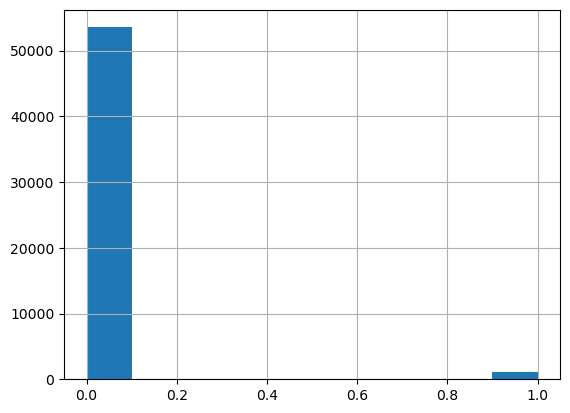

In [11]:
labels.cancer.hist()

#### Data contain some Nan values. The present model is not involving this data, but the improvement of the model will include this data. The next model should be built using the features from convolutional layers and also the data stored in the 'labels' dataframe. 

494
(25236,)
B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64


<AxesSubplot:>

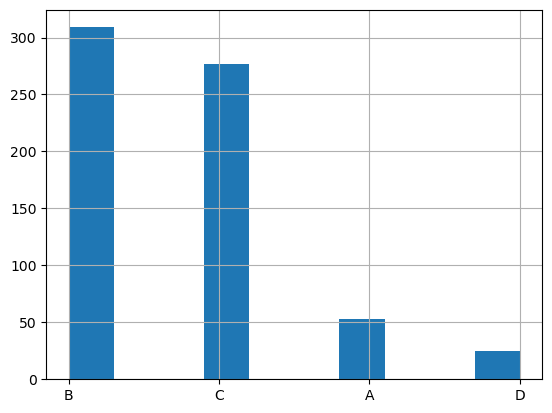

In [12]:
print(labels[labels.density.isnull()]['cancer'].sum())
print(labels[labels.density.isnull()]['cancer'].shape)
print(labels.density.value_counts())
labels[labels.cancer == 1]['density'].hist()

In [13]:
# since B is the most common density in both cases, with an without cancer, the nan values will be replaced with B
labels.density = labels.density.fillna('B')

In [14]:
print(labels.BIRADS.isnull().sum())
labels[labels.cancer == 1]['BIRADS'].sum()
#everywhere where the cancer is 1 BIRADS is 0

28420


0.0

<AxesSubplot:>

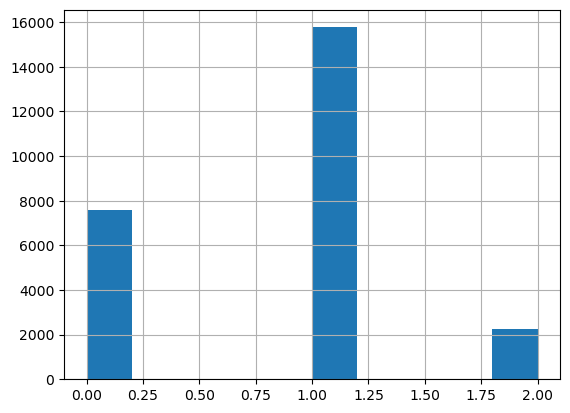

In [15]:
labels[labels.cancer == 0]['BIRADS'].hist()

In [16]:
labels['BIRADS'] = labels.groupby('cancer')['BIRADS'].transform(lambda value: value.fillna(round(value.mean(),0)))

In [17]:
labels[labels.cancer == 1 & labels.age.isnull()].shape

(53511, 14)

In [18]:
labels[labels.cancer == 1 & labels.age.isnull()].shape

(53511, 14)

In [19]:
labels[labels.age.isnull()].sum()
labels[labels.site_id == 1]['age'].mean()
labels[labels.machine_id == 49]['age'].mean()
labels.age.mean()

58.54392800307304

In [20]:
labels.age.isnull().sum()

37

In [21]:
labels[labels.cancer==0]['age'].isnull().sum()

37

In [22]:
labels[labels.cancer==1]['age'].isnull().sum()

0

In [23]:
labels[labels.cancer == 1]['age'].describe()

count    1158.000000
mean       63.678756
std         9.991980
min        38.000000
25%        56.000000
50%        64.500000
75%        71.000000
max        89.000000
Name: age, dtype: float64

In [24]:
labels[labels.cancer == 0]['age'].describe()

count    53511.000000
mean        58.432808
std         10.023210
min         26.000000
25%         51.000000
50%         58.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

In [25]:
labels.age = labels.age.fillna(58)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54706 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   54706 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  54706 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

### Storing the data in the directory in order to be usable by the DataLoader.

In [26]:
ROOT_PATH = Path('/kaggle/input/rsna-breast-cancer-detection/train_images')
SAVE_PATH = Path('/kaggle/working/Processed/')

In [27]:
patient_ID = labels.patient_id.apply(lambda x:str(x)).unique().tolist()
len(patient_ID)

11913

In [28]:
patient_ID[3000]

'24698'

In [29]:
image_ID = labels.image_id

In [31]:
patient_ID.index('24698')


3000

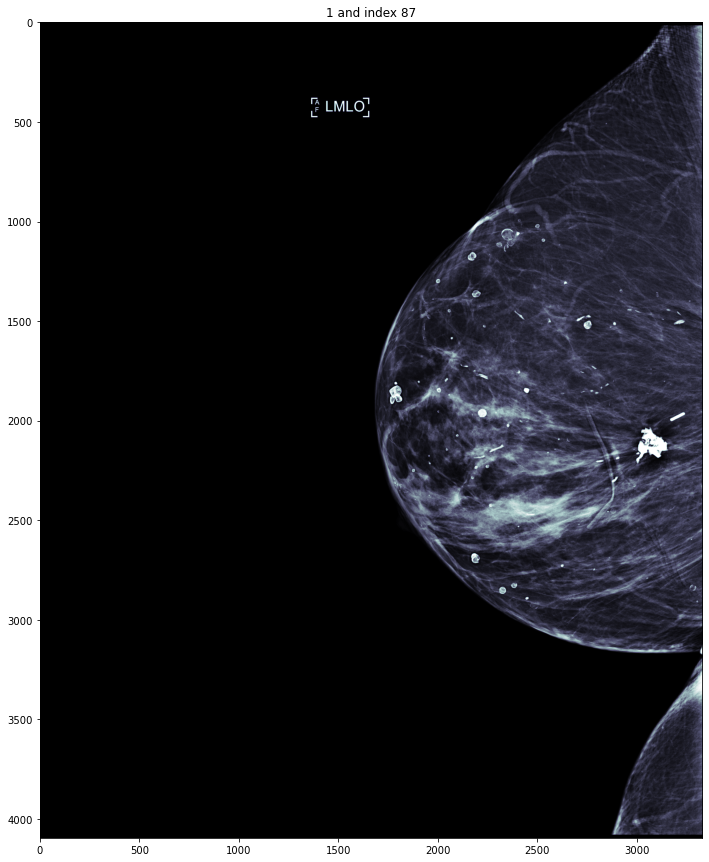

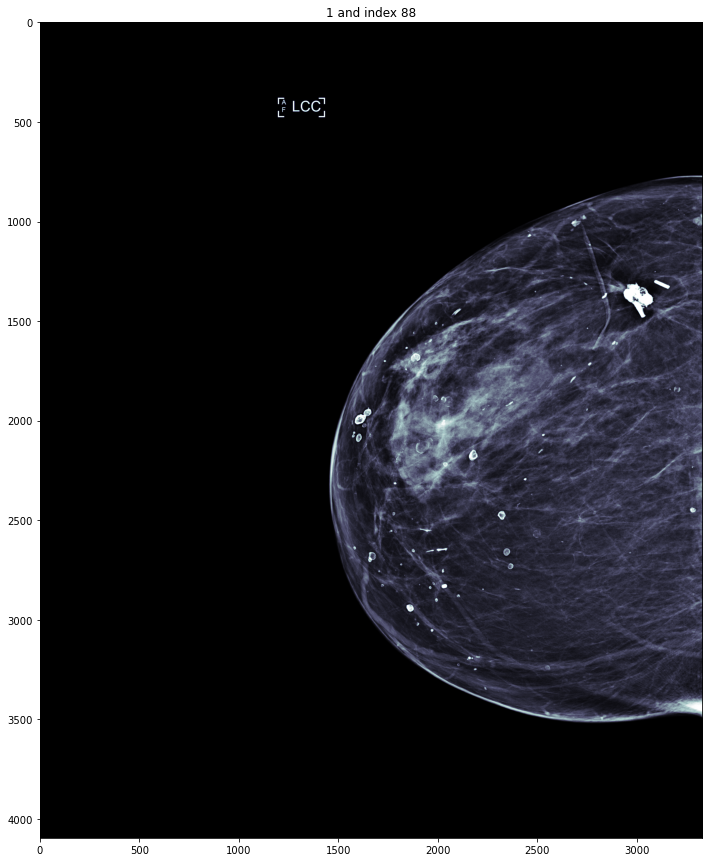

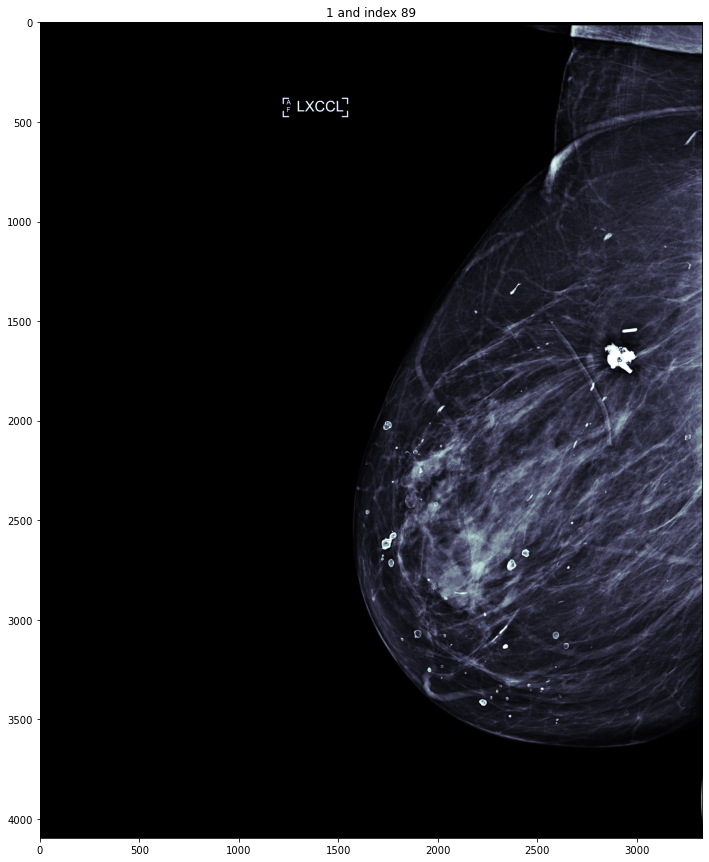

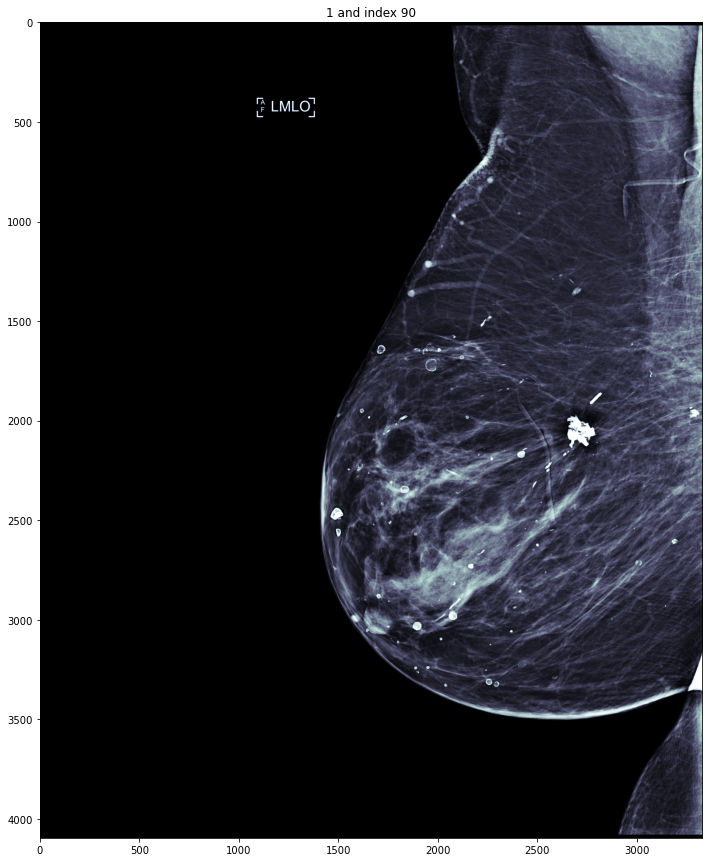

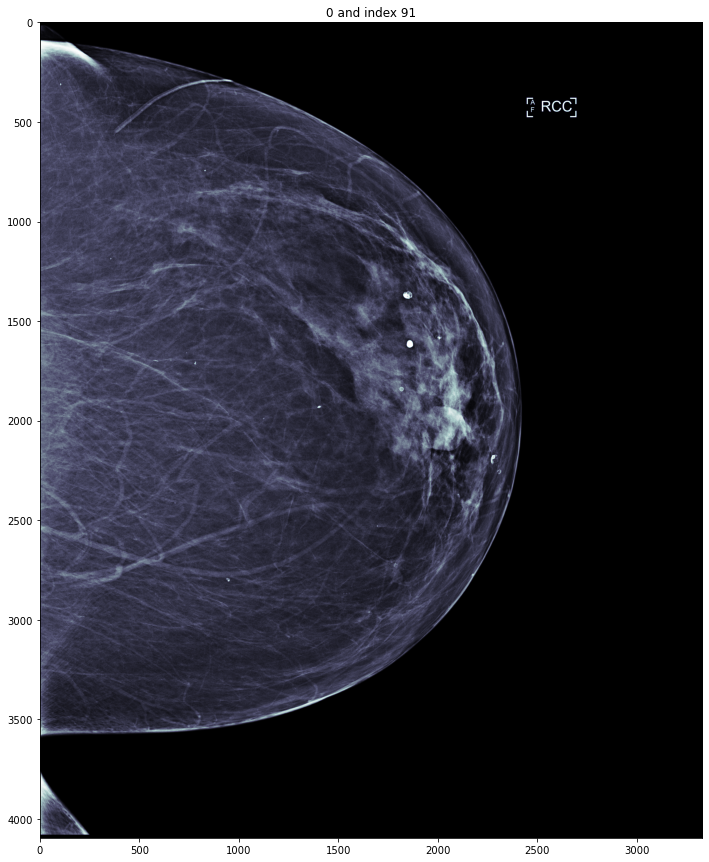

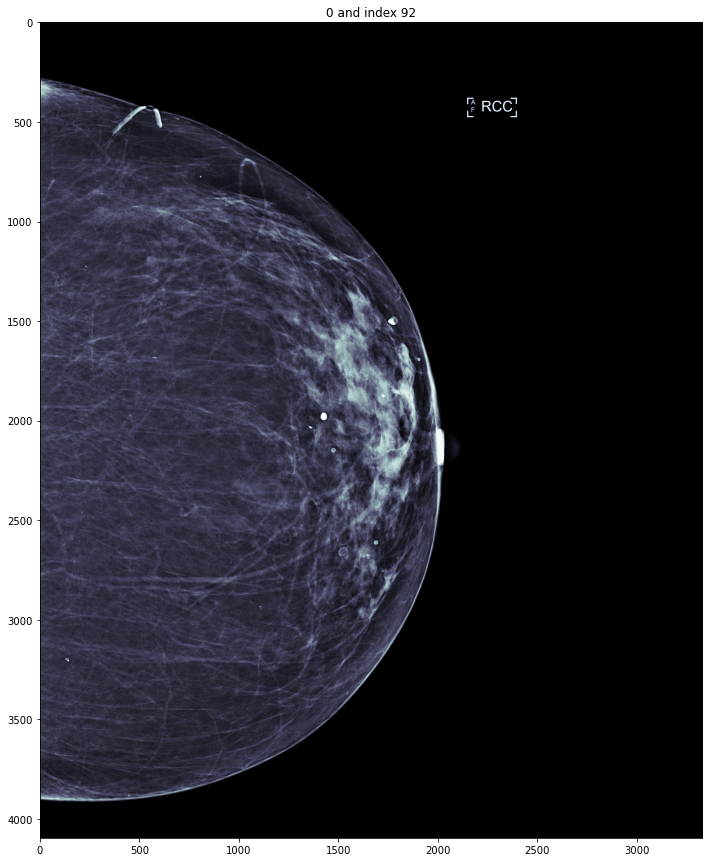

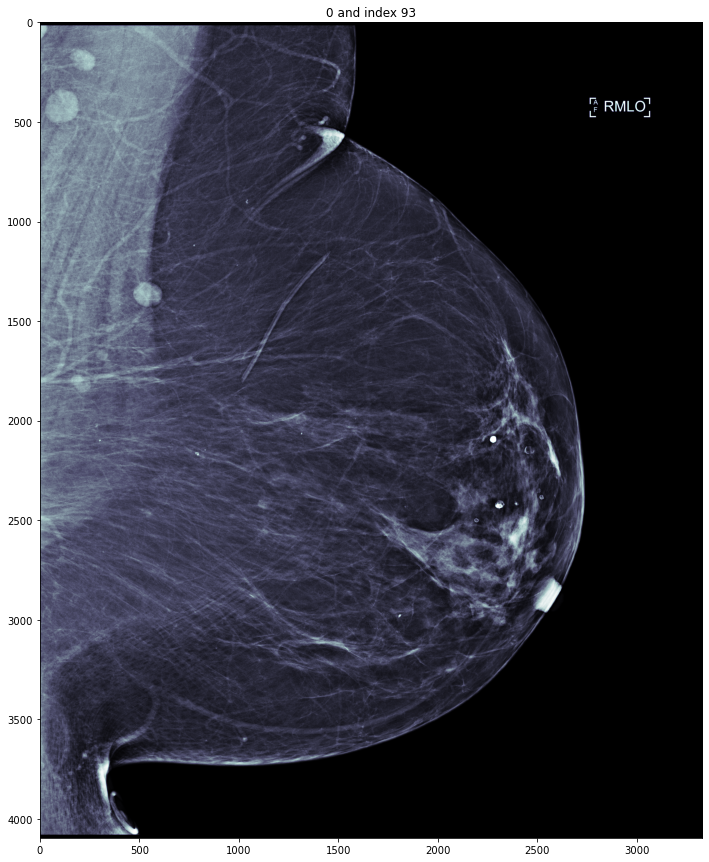

In [86]:
labels_im = []
dcm_paths = []
c = 19
for index,item in (labels[labels.patient_id == int(patient_ID[c])]['image_id'].items()):
    item = str(item)

    dcm_path = ROOT_PATH/patient_ID[c]/item
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm_paths.append(dcm_path)

    dcm = pydicom.dcmread(dcm_path).pixel_array

    label = labels['cancer'].iloc[index]
    plt.figure(figsize=(15,15))
    plt.imshow(dcm, cmap='bone')

    plt.title(f'{label} and index {index}')


In [32]:
for c, patient_ID_item in enumerate(tqdm(patient_ID[:3000])):
    dcm_path = ROOT_PATH/patient_ID_item
    
    for index,item in (labels[labels.patient_id == int(patient_ID_item)]['image_id'].items()):
        item = str(item)
        
        dcm_path = ROOT_PATH/patient_ID_item/item
        dcm_path = dcm_path.with_suffix('.dcm')
        
        
        dcm = pydicom.dcmread(dcm_path).pixel_array / 4095
    
        # resize the image to 224x224, and convert it to float16
        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
        label = str(labels.cancer.iloc[index])
        # 80% train split and 20% validation split
        train_or_val = 'train' if c < 3000 else 'val' # check in your dataset what number is giving this split
    
        current_save_path = SAVE_PATH/train_or_val/label #define save path and create if necessary
        current_save_path.mkdir(parents=True, exist_ok=True)
        
        np.save(current_save_path/item, dcm_array)  #save the array in the corresponding directory
    

  0%|          | 0/3000 [00:00<?, ?it/s]

In [36]:
for c, patient_ID_item in enumerate(tqdm(patient_ID[3000:3300])):
    dcm_path = ROOT_PATH/patient_ID_item
    
    for index,item in (labels[labels.patient_id == int(patient_ID_item)]['image_id'].items()):
        item = str(item)
        
        dcm_path = ROOT_PATH/patient_ID_item/item
        dcm_path = dcm_path.with_suffix('.dcm')
        
        dcm = pydicom.dcmread(dcm_path).pixel_array / 4095
    
    # resize the image to 224x224, and convert it to float16
        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
        label = str(labels.cancer.iloc[index])
        # 80% train split and 20% validation split
        #train_or_val = 'train' if c  43765 else 'val' # check in your dataset what number is giving this split
    
        current_save_path = SAVE_PATH/'val'/label #define save path and create if necessary
        current_save_path.mkdir(parents=True, exist_ok=True)
        
        np.save(current_save_path/item, dcm_array)  #save the array in the corresponding directory
    

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
SAVE_PATH

In [37]:
len(os.listdir(SAVE_PATH/'train'/'1')) + len(os.listdir(SAVE_PATH/'train'/'0'))+len(os.listdir(SAVE_PATH/'val'/'1')) + len(os.listdir(SAVE_PATH/'val'/'0'))


15077

In [82]:
img_names = []

for folder, subfolders, filenames in os.walk(SAVE_PATH):

    for img in filenames:
        img_names.append(folder+'/'+img)


## Model - ResNet18
Importing libraries for the model

In [31]:
import torchvision
from torchvision import transforms
import torchmetrics
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


In [53]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485],[0.229])
   
    
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485],[0.229])
])

In [34]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [35]:
train_dataset = torchvision.datasets.DatasetFolder(
    '/kaggle/working/Processed/train/',
    loader=load_file, extensions='npy', transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    '/kaggle/working/Processed/val/',
    loader=load_file, extensions='npy', transform=val_transforms)

In [141]:
len(val_dataset)


1366

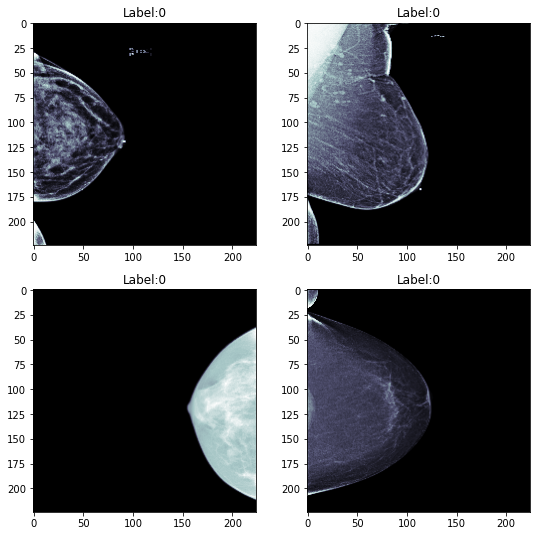

In [37]:
#Inspection of some augmented train images         
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [36]:
batch_size = 8
num_workers = 4 #?

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f'There are {len(train_dataset)} train images and {len(val_dataset)} val images')

There are 13711 train images and 1366 val images


In [37]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([13441,   270])), (array([0, 1]), array([1327,   39])))

In [163]:
class BCCModel(pl.LightningModule):
    def __init__(self, weight=50):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-6)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [164]:
model = BCCModel()

In [165]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [166]:
gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

In [167]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [168]:
for folder, subfolders, filenames in os.walk("/kaggle/working/logs/lightning_logs/"):
    print(folder)
    print(subfolders)
    print(filenames)
    

/kaggle/working/logs/lightning_logs/
['version_0', 'version_2', 'version_1']
[]
/kaggle/working/logs/lightning_logs/version_0
['checkpoints']
['events.out.tfevents.1677516495.0e6bd7aa4d78.23.0', 'hparams.yaml']
/kaggle/working/logs/lightning_logs/version_0/checkpoints
[]
['epoch=34-step=59990.ckpt', 'epoch=31-step=54848.ckpt', 'epoch=28-step=49706.ckpt', 'epoch=0-step=1714.ckpt', 'epoch=29-step=51420.ckpt', 'epoch=27-step=47992.ckpt', 'epoch=30-step=53134.ckpt', 'epoch=33-step=58276.ckpt', 'epoch=32-step=56562.ckpt', 'epoch=1-step=3428.ckpt']
/kaggle/working/logs/lightning_logs/version_2
['checkpoints']
['events.out.tfevents.1677521857.0e6bd7aa4d78.23.2', 'hparams.yaml']
/kaggle/working/logs/lightning_logs/version_2/checkpoints
[]
['epoch=16-step=29138.ckpt', 'epoch=12-step=22282.ckpt', 'epoch=11-step=20568.ckpt', 'epoch=14-step=25710.ckpt', 'epoch=18-step=32566.ckpt', 'epoch=15-step=27424.ckpt', 'epoch=17-step=30852.ckpt', 'epoch=13-step=23996.ckpt', 'epoch=20-step=35994.ckpt', 'epoch

### Model Evaluation

In [172]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = BCCModel.load_from_checkpoint("/kaggle/working/logs/lightning_logs/version_1/checkpoints/epoch=9-step=17140.ckpt")
model.eval()
model.to(device);

In [173]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/1366 [00:00<?, ?it/s]

In [174]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.7496339678764343
Val Precision: 0.06590257585048676
Val Recall: 0.5897436141967773
Confusion Matrix:
 tensor([[1001,  326],
        [  16,   23]])
Confusion Matrix 2:
 tensor([[   0, 1327],
        [   0,   39]])


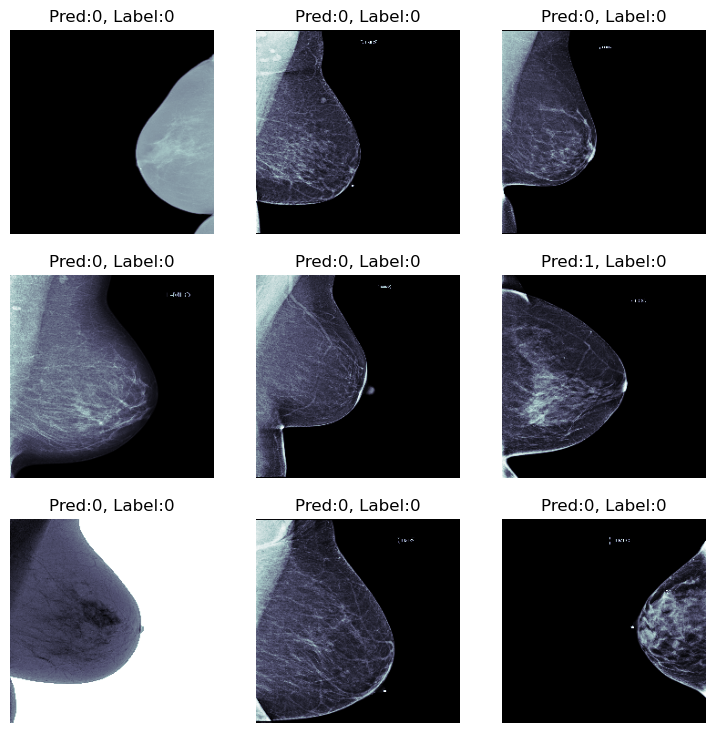

In [175]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")